In [1]:
!pip install timm

In [2]:
from IPython import display
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time
import random
from utils import load_model


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
colab = False
if colab:
    chemin = "/content/drive/Othercomputers/My laptop/Documents/Master ISN/M2/Projet_fevr/Projet1/Données"
else : 
    chemin = os.getcwd()+"/Données"

In [5]:
def resize_and_rotate(x, angle=0):
    '''
    redimentionne les images + exécute une rotation de "angle" degrés
    '''
    trans = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(angle)])
    return trans(x)


def expansion_img(tensor, nb_angles):
    '''
    Pivote les photos et les ajoutent à la fin du tensor
    '''
    angles = np.linspace(0, 360, num=nb_angles+1)
    angles = angles[:-1]
    new_tensor = torch.zeros((tensor.shape[0] * nb_angles, tensor.shape[1], tensor.shape[2], tensor.shape[3]))
    for i in range(tensor.shape[0]):
        for j, angle in enumerate(angles):
            new_tensor[i*nb_angles + j] = resize_and_rotate(tensor[i], angle)
    return new_tensor


def labels_increase(tensor, nb_angles):
    '''
    adapte la taille du tensor labels 
    '''
    new_tensor = torch.zeros(tensor.shape[0] * nb_angles, dtype=torch.long)
    for i in range(tensor.shape[0]):
        for j in range(nb_angles):
            new_tensor[i*nb_angles + j] = tensor[i]
    return new_tensor

In [6]:
typeFleur =  [species for species in os.listdir(chemin) if os.path.isdir(f"{chemin}/{species}")] # liste des espèce (17)
transform = transforms.Resize((224, 224))

Names={}
nb=0
# création dico({Espèce : list_fichier.jpg})
for type_ in typeFleur:     
    filenames = [name for name in os.listdir(f"{chemin}/{type_}") if os.path.splitext(name)[-1] == '.jpg']
    nb+=len(filenames)
    Names[type_]=filenames

    
batch = torch.zeros(nb, 3, 224, 224, dtype=torch.float32)
labels=np.empty(nb, dtype="U20")
i=-1

# on parcour le dico et on place chaque image dans le tensor batch
#                                      espece dans l'array labels
for espece, list_img in Names.items():
    for name in list_img:                                     
        i+=1 
        print(f"{i+1}/{nb}")
        display.clear_output(wait=True)
        image = transform(torchvision.io.read_image(f"{chemin}/{espece}/{name}"))/255.0   # redimension (224x224) et standardisation
        batch[i] = image
        labels[i]=espece

y = torch.as_tensor(preprocessing.LabelEncoder().fit_transform(labels))  # labels en chiffres
X = batch

1360/1360


In [12]:
batch_size = 4

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

increase = 4   # on augmente la taille du jeu de données d'un facteur increase
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = expansion_img(X_train, increase)   # on augmente la taille uniquement de l'échant train
y_train = labels_increase(y_train, increase)

train_dataset = data.TensorDataset(X_train, y_train)
test_dataset = data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
filename = 'resnet18_weights_best_acc.tar' # pre-trained model path
use_gpu = True  # load weights on the gpu
model = resnet18(num_classes=1081).to(device) # 1081 classes in Pl@ntNet-300K
load_model(model, filename=filename, use_gpu=use_gpu)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features     #nombre de neuron dernière couche entièrement connecté 
model.fc = nn.Linear(num_ftrs, 17)  # changement de la dernière couche entièrement connectée
model = model.to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [15]:
num_epochs=10
n_total_steps = len(train_loader)
accur = [0 for i in range(num_epochs)]
start_time = time.time()
for epoch in range(num_epochs):
    train_acc = 0
    n_samples = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        model.train()
        # Forward pass
        outputs = model(images)  #shape :  batch_size, 17
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        display.clear_output(wait=True)
#         _, predicted = torch.max(outputs, 1)
#         n_samples += labels.size(0)
#         train_acc += (predicted == labels).sum().item()
#         accur[epoch]=train_acc/n_samples*100 
        
        print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}') 
print(f'Finished Training')
end_time = time.time()


Epoch [10/10], Step [1088/1088], Loss: 0.6435
Finished Training


In [16]:
print(f"Durée d'exécution : {int((end_time - start_time)//60)} minutes et {int((end_time - start_time)%60)} secondes")

Durée d'exécution : 49 minutes et 11 secondes


In [17]:
# évaluation   
# model.eval()
with torch.no_grad():
    prediction = []
    espece = []
    n_correct = 0
    n_samples = 0
    model.eval()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)        # shape : bach_size, 17 
        _, predicted = torch.max(outputs, 1)  # max sur chaque ligne
        n_samples += labels.size(0)  # incrémente de batch_size à chaque itération
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            espece.append(labels[i])
            prediction.append(predicted[i])

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 94.23253676470588 %


In [18]:
# évaluation   
# model.eval()
with torch.no_grad():
    prediction = []
    espece = []
    n_correct = 0
    n_samples = 0
    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)        # shape : bach_size, 17 
        _, predicted = torch.max(outputs, 1)  # max sur chaque ligne
        n_samples += labels.size(0)  # incrémente de batch_size à chaque itération
        n_correct += (predicted == labels).sum().item()

        for i in range(batch_size):
            espece.append(labels[i])
            prediction.append(predicted[i])

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')


Accuracy of the network: 95.95588235294117 %


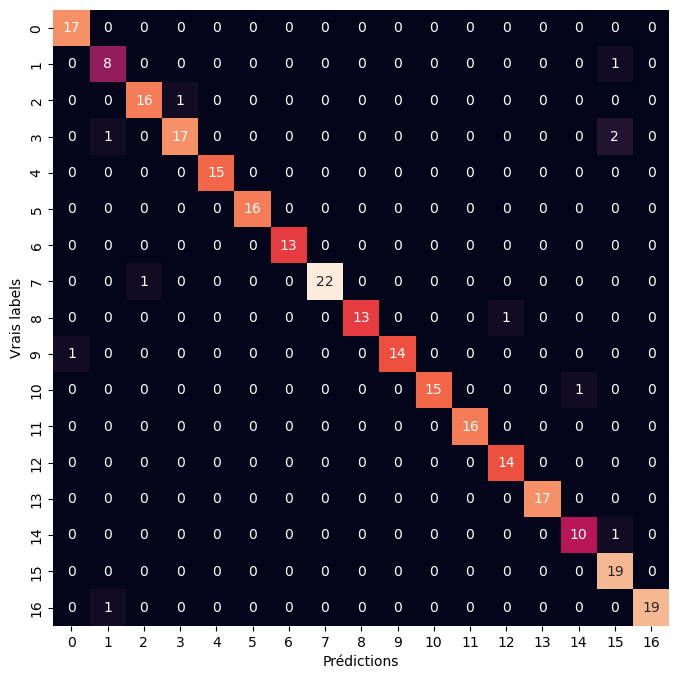

In [19]:
confusionX=confusion_matrix(espece,prediction)

plt.figure(figsize=(8,8))  # set plot size (denoted in inches)
sns.heatmap(confusionX,square=True, fmt='d', cbar=False ,annot=True)

plt.xlabel("Prédictions")
plt.ylabel("Vrais labels")
plt.show()

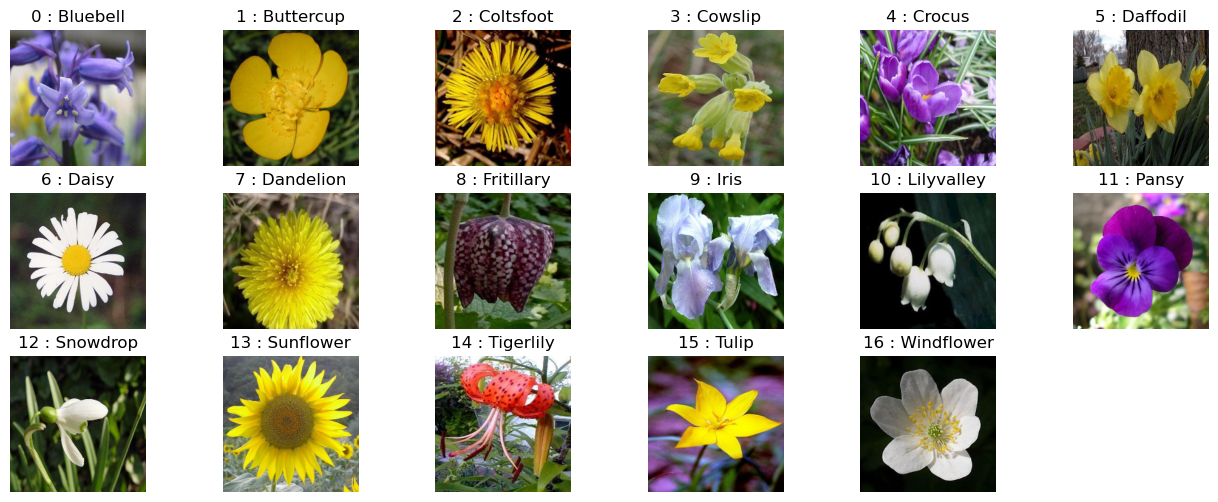

In [20]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(17):
    img = (80*i)
    plt.subplot(3, 6, i+1)
    image = X[img]
    plt.title(f"{i} : {typeFleur[i]}")
    plt.imshow(np.transpose(image, (1,2,0)))  # image.shape ==> (dim(RGB)=3, longueur, largeur)
    plt.axis('off'); 